### Title: Rainfall Analysis of Andhra Pradesh (2023)

### Objectives
The main goal of this project is to analyze rainfall patterns in various districts of Andhra Pradesh during 2023 using PySpark for distributed data processing and Matplotlib/Seaborn for visual analytics.

Specific objectives include:

✅ Load and explore rainfall data for Andhra Pradesh (2023).

✅ Identify average rainfall per district.

✅ Analyze monthly rainfall variations across the state.

✅ Detect seasonal rainfall patterns (quarter-wise).

✅ Identify the wettest and driest districts.

✅ Visualize rainfall distributions and outliers.

✅ Compare districts having above-average rainfall.

✅ Explore the correlation between rainfall and other numerical variables.

✅ Present clear, data-driven insights using visualizations.

In [1]:
pip install pyspark findspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("HelloSpark").getOrCreate()
print("Spark version:", spark.version)


Spark version: 3.5.6


###  Import Required Libraries



In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, max, min, sum, count, month, year, desc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


###  Create a Spark Session


In [4]:
spark = SparkSession.builder.appName("AndhraPradesh_Rainfall_2023").getOrCreate()


###  Load the Rainfall Dataset



In [5]:
file_path = "AndhraPradesh_Rainfall_2023.csv"
rain_df = spark.read.csv(file_path, header=True, inferSchema=True)
rain_df.show(5)


+--------------+--------+----------+----+-----+------------+--------------+
|         State|District|      Date|Year|Month|Avg_rainfall|   Agency_name|
+--------------+--------+----------+----+-----+------------+--------------+
|Andhra Pradesh|Prakasam|10/21/2023|2023|   10| 0.071610535|IMD GRID MODEL|
|Andhra Pradesh|Prakasam|10/24/2023|2023|   10|         0.0|IMD GRID MODEL|
|Andhra Pradesh|Prakasam|10/25/2023|2023|   10|         0.0|IMD GRID MODEL|
|Andhra Pradesh|Prakasam|10/26/2023|2023|   10|         0.0|IMD GRID MODEL|
|Andhra Pradesh|Prakasam|10/29/2023|2023|   10| 0.170459658|IMD GRID MODEL|
+--------------+--------+----------+----+-----+------------+--------------+
only showing top 5 rows



In [6]:
rain_df.printSchema()


root
 |-- State: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Avg_rainfall: double (nullable = true)
 |-- Agency_name: string (nullable = true)



###  Summary Statistics


In [7]:
rain_df.describe().show()


+-------+--------------+---------+--------+------+------------------+------------------+--------------+
|summary|         State| District|    Date|  Year|             Month|      Avg_rainfall|   Agency_name|
+-------+--------------+---------+--------+------+------------------+------------------+--------------+
|  count|          4745|     4745|    4745|  4745|              4745|              4745|          4745|
|   mean|          NULL|     NULL|    NULL|2023.0| 6.526027397260274|2.5699839056063225|          NULL|
| stddev|          NULL|     NULL|    NULL|   0.0|3.4482146936419404| 7.804739848452854|          NULL|
|    min|Andhra Pradesh|Anantapur|1/1/2023|  2023|                 1|               0.0|IMD GRID MODEL|
|    max|Andhra Pradesh|   Y.S.R.|9/9/2023|  2023|                12|       188.5136234|IMD GRID MODEL|
+-------+--------------+---------+--------+------+------------------+------------------+--------------+



### Missing Values Detection


In [8]:
from pyspark.sql.functions import sum as _sum, when
rain_df.select([_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in rain_df.columns]).show()


+-----+--------+----+----+-----+------------+-----------+
|State|District|Date|Year|Month|Avg_rainfall|Agency_name|
+-----+--------+----+----+-----+------------+-----------+
|    0|       0|   0|   0|    0|           0|          0|
+-----+--------+----+----+-----+------------+-----------+



###  Average Rainfall per District


In [9]:
avg_rain = rain_df.groupBy("District").agg(avg("Avg_rainfall").alias("Avg_Rainfall"))
avg_rain.show()


+--------------+------------------+
|      District|      Avg_Rainfall|
+--------------+------------------+
| East Godavari|3.3058277970657532|
|  Vizianagaram|3.1585270032849317|
|       Krishna|3.2237049917945195|
|    Srikakulam|2.3178937195972615|
|        Y.S.R.|1.8334446938931495|
|     Anantapur| 1.368294995473972|
| West Godavari| 3.418071192983563|
|Visakhapatanam|3.3000524807945206|
|        Guntur|2.7600268735095894|
|      Prakasam|2.2530600818493136|
|  SPSR Nellore|  2.45600730709041|
|      Chittoor|2.4960268313561644|
|       Kurnool|1.5188528041890414|
+--------------+------------------+



In [10]:
monthly_rain = rain_df.groupBy("Month").agg(sum("Avg_rainfall").alias("Total_Rainfall")).orderBy("Month")
monthly_rain.show()


+-----+------------------+
|Month|    Total_Rainfall|
+-----+------------------+
|    1|13.827685164000004|
|    2|       0.542354268|
|    3| 737.2335819489998|
|    4| 370.1673450930001|
|    5|1143.5178337379994|
|    6| 884.4769640670002|
|    7|2688.6234007700014|
|    8|1151.2845404039992|
|    9|2369.4185057550003|
|   10|213.89124694300017|
|   11| 808.0676112869996|
|   12|    1813.522562664|
+-----+------------------+



In [11]:
top_days = rain_df.orderBy(desc("Avg_rainfall")).limit(5)
top_days.show()


+--------------+--------------+---------+----+-----+------------+--------------+
|         State|      District|     Date|Year|Month|Avg_rainfall|   Agency_name|
+--------------+--------------+---------+----+-----+------------+--------------+
|Andhra Pradesh| West Godavari|12/6/2023|2023|   12| 188.5136234|IMD GRID MODEL|
|Andhra Pradesh|       Krishna|12/6/2023|2023|   12| 144.7911778|IMD GRID MODEL|
|Andhra Pradesh|  SPSR Nellore|12/5/2023|2023|   12| 141.0618216|IMD GRID MODEL|
|Andhra Pradesh| East Godavari|12/6/2023|2023|   12| 128.0002104|IMD GRID MODEL|
|Andhra Pradesh|Visakhapatanam|12/6/2023|2023|   12| 109.8905922|IMD GRID MODEL|
+--------------+--------------+---------+----+-----+------------+--------------+



In [12]:
overall_avg = rain_df.agg(avg("Avg_rainfall")).collect()[0][0]
above_avg = avg_rain.filter(col("Avg_Rainfall") > overall_avg)
above_avg.show()


+--------------+------------------+
|      District|      Avg_Rainfall|
+--------------+------------------+
| East Godavari|3.3058277970657532|
|  Vizianagaram|3.1585270032849317|
|       Krishna|3.2237049917945195|
| West Godavari| 3.418071192983563|
|Visakhapatanam|3.3000524807945206|
|        Guntur|2.7600268735095894|
+--------------+------------------+



In [28]:
peak_month = rain_df.groupBy("Month").agg(_sum("Avg_rainfall").alias("Total_Rainfall")) \
                    .orderBy("Total_Rainfall", ascending=False).limit(1)
peak_month.show()


+-----+------------------+
|Month|    Total_Rainfall|
+-----+------------------+
|    7|2688.6234007700014|
+-----+------------------+



###  Visualization: Average Rainfall per District



C:\Users\chandu thanneru\AppData\Local\Temp\ipykernel_2704\3562312660.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_rain_pd, x="District", y="Avg_Rainfall", palette="coolwarm")


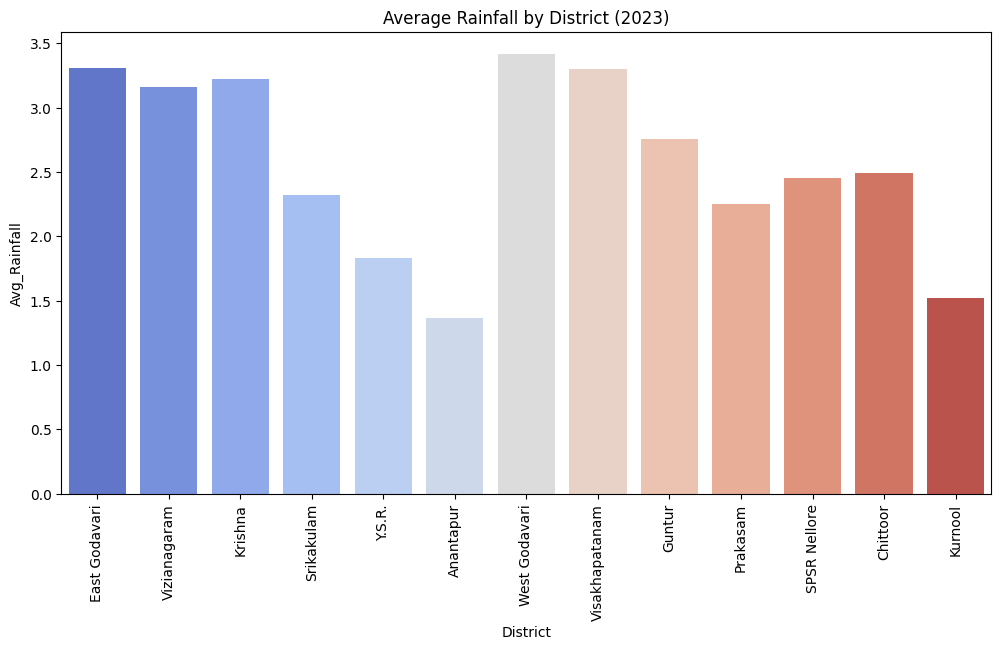

In [13]:
avg_rain_pd = avg_rain.toPandas()
plt.figure(figsize=(12,6))
sns.barplot(data=avg_rain_pd, x="District", y="Avg_Rainfall", palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Average Rainfall by District (2023)")
plt.show()


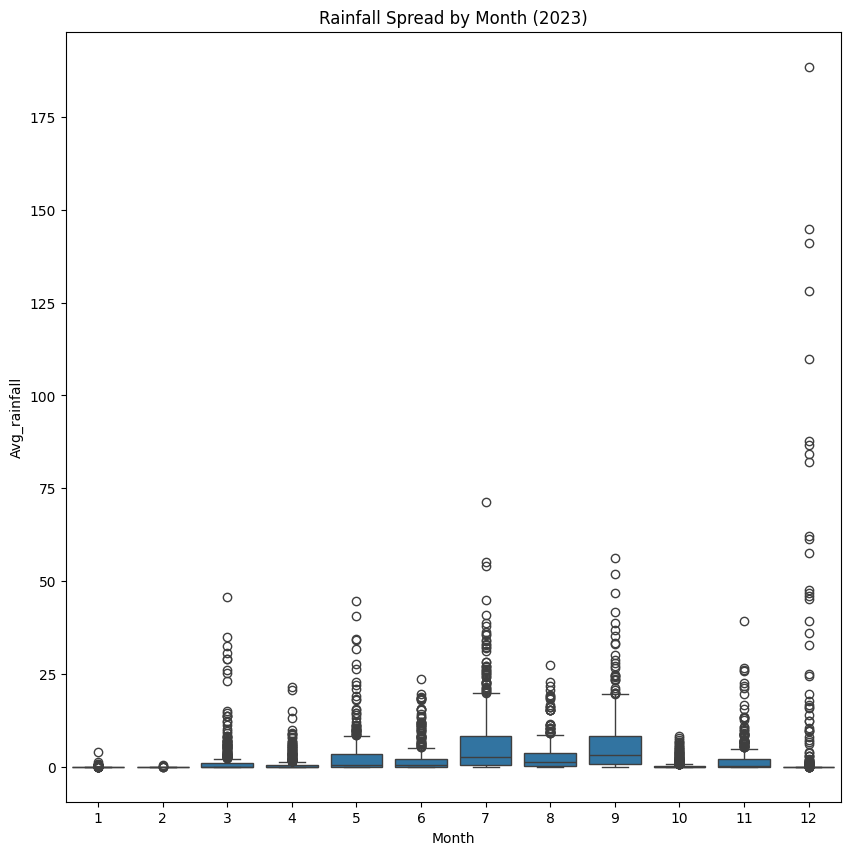

In [14]:
rain_pd = rain_df.select("Month", "Avg_rainfall").toPandas()
plt.figure(figsize=(10,10))
sns.boxplot(data=rain_pd, x="Month", y="Avg_rainfall")
plt.title("Rainfall Spread by Month (2023)")
plt.show()


### 📈 Visualization: Monthly Rainfall Trend



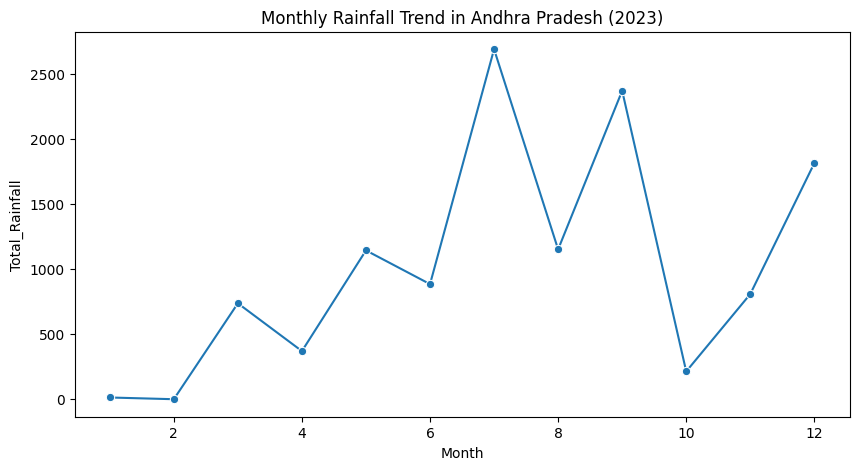

In [15]:
monthly_pd = monthly_rain.toPandas()
plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_pd, x="Month", y="Total_Rainfall", marker='o')
plt.title("Monthly Rainfall Trend in Andhra Pradesh (2023)")
plt.show()


###  Identify Wettest and Driest Districts


In [16]:
max_rain = avg_rain.orderBy(desc("Avg_Rainfall")).first()
min_rain = avg_rain.orderBy("Avg_Rainfall").first()
print("🌧️ Wettest District:", max_rain)
print("☀️ Driest District:", min_rain)


🌧️ Wettest District: Row(District='West Godavari', Avg_Rainfall=3.418071192983563)
☀️ Driest District: Row(District='Anantapur', Avg_Rainfall=1.368294995473972)


### Rainfall Distribution



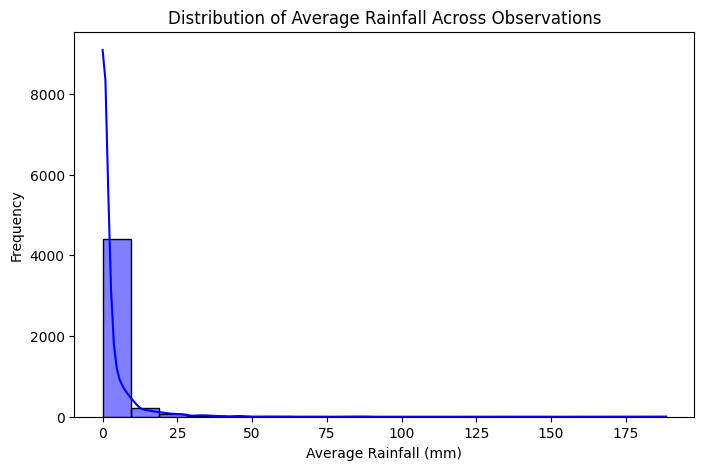

In [17]:
rain_pd = rain_df.select("Avg_rainfall").toPandas()
plt.figure(figsize=(8,5))
sns.histplot(rain_pd["Avg_rainfall"], bins=20, kde=True, color='blue')
plt.title("Distribution of Average Rainfall Across Observations")
plt.xlabel("Average Rainfall (mm)")
plt.ylabel("Frequency")
plt.show()


###  Correlation Between Numeric Features



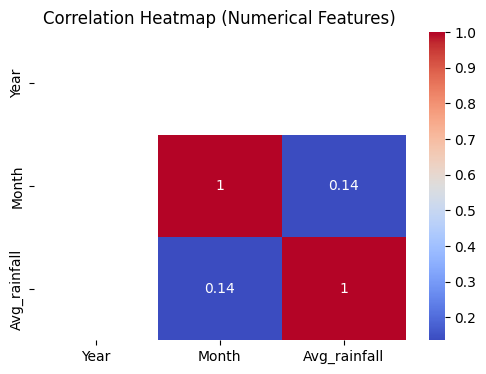

In [18]:

from pyspark.sql.types import NumericType
numeric_cols = [field.name for field in rain_df.schema.fields if isinstance(field.dataType, NumericType)]
if len(numeric_cols) > 1:
    corr_pd = rain_df.select(numeric_cols).toPandas().corr()
    plt.figure(figsize=(6,4))
    sns.heatmap(corr_pd, annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap (Numerical Features)")
    plt.show()
else:
    print("Not enough numeric columns for correlation.")



###  Seasonal Rainfall (Quarter-wise)



In [19]:
from pyspark.sql.functions import quarter, col, sum as _sum

# Group by quarter based on the Date column
seasonal = rain_df.withColumn("Quarter", quarter(col("Date"))) \
                  .groupBy("Quarter") \
                  .agg(_sum("Avg_rainfall").alias("Total_Rainfall"))

seasonal.show()


+-------+---------------+
|Quarter| Total_Rainfall|
+-------+---------------+
|   NULL|12194.573632102|
+-------+---------------+



### Top 5 Rainiest Days



In [20]:
top_days = rain_df.orderBy(desc("Avg_rainfall")).limit(5)
top_days.show()

+--------------+--------------+---------+----+-----+------------+--------------+
|         State|      District|     Date|Year|Month|Avg_rainfall|   Agency_name|
+--------------+--------------+---------+----+-----+------------+--------------+
|Andhra Pradesh| West Godavari|12/6/2023|2023|   12| 188.5136234|IMD GRID MODEL|
|Andhra Pradesh|       Krishna|12/6/2023|2023|   12| 144.7911778|IMD GRID MODEL|
|Andhra Pradesh|  SPSR Nellore|12/5/2023|2023|   12| 141.0618216|IMD GRID MODEL|
|Andhra Pradesh| East Godavari|12/6/2023|2023|   12| 128.0002104|IMD GRID MODEL|
|Andhra Pradesh|Visakhapatanam|12/6/2023|2023|   12| 109.8905922|IMD GRID MODEL|
+--------------+--------------+---------+----+-----+------------+--------------+



### Districts with Above-Average Rainfall



In [21]:
from pyspark.sql.functions import avg, col
overall_avg = rain_df.agg(avg("Avg_rainfall")).collect()[0][0]
avg_rain = rain_df.groupBy("District").agg(avg("Avg_rainfall").alias("Avg_Rainfall"))
above_avg = avg_rain.filter(col("Avg_Rainfall") > overall_avg)

above_avg.show()


+--------------+------------------+
|      District|      Avg_Rainfall|
+--------------+------------------+
| East Godavari|3.3058277970657532|
|  Vizianagaram|3.1585270032849317|
|       Krishna|3.2237049917945195|
| West Godavari| 3.418071192983563|
|Visakhapatanam|3.3000524807945206|
|        Guntur|2.7600268735095894|
+--------------+------------------+



## 🌦 Monthly Rainfall Trend in Andhra Pradesh (2023)



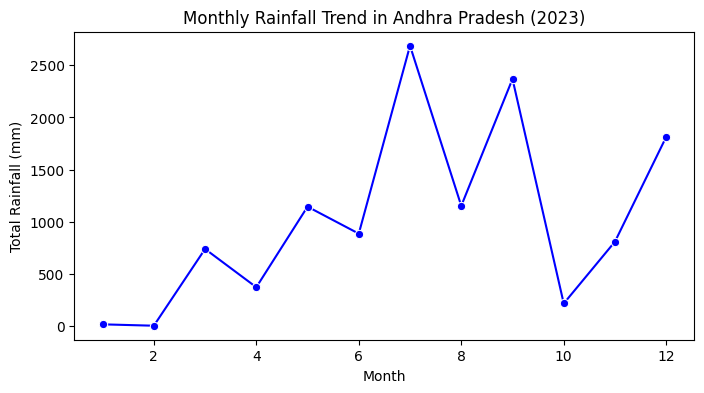

In [22]:
monthly_rain = rain_df.groupBy("Month").agg(_sum("Avg_rainfall").alias("Total_Rainfall"))
monthly_pd = monthly_rain.toPandas()

plt.figure(figsize=(8,4))
sns.lineplot(data=monthly_pd, x="Month", y="Total_Rainfall", marker="o", color="blue")
plt.title("Monthly Rainfall Trend in Andhra Pradesh (2023)")
plt.xlabel("Month")
plt.ylabel("Total Rainfall (mm)")
plt.show()



## 📍 District-wise Average Rainfall



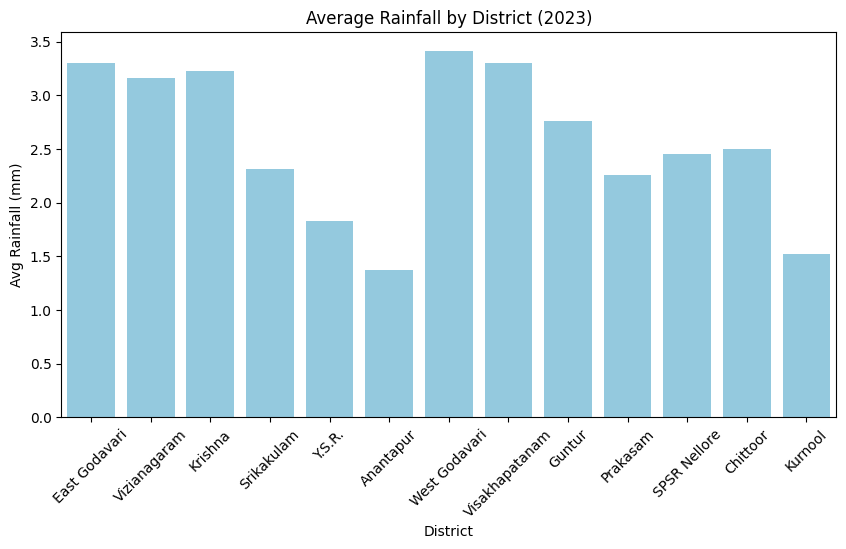

In [23]:
district_avg = rain_df.groupBy("District").agg(avg("Avg_rainfall").alias("Avg_Rainfall"))
district_pd = district_avg.toPandas()

plt.figure(figsize=(10,5))
sns.barplot(
    data=district_pd,
    x="District",
    y="Avg_Rainfall",
    color="skyblue"   # single color instead of palette
)
plt.title("Average Rainfall by District (2023)")
plt.xticks(rotation=45)
plt.ylabel("Avg Rainfall (mm)")
plt.show()

##  Top 10 Wettest Districts



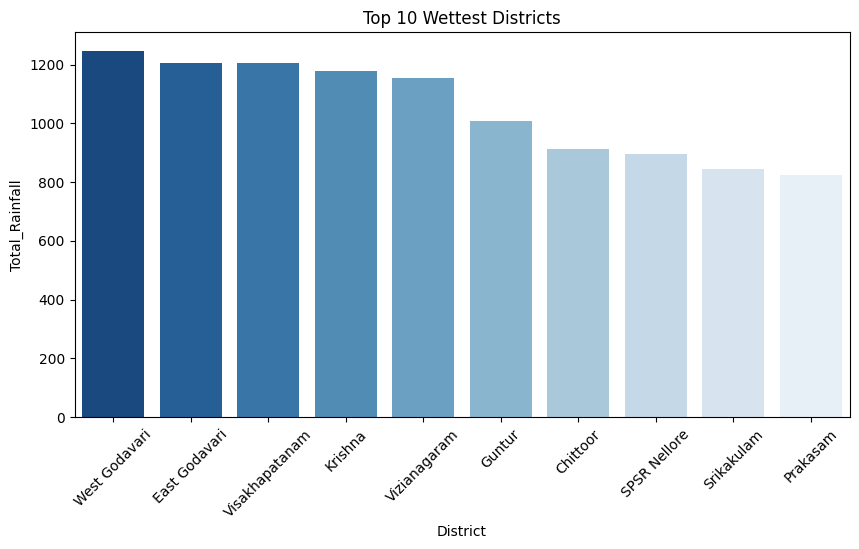

In [24]:
wettest = rain_df.groupBy("District").agg(_sum("Avg_rainfall").alias("Total_Rainfall")) \
                 .orderBy(desc("Total_Rainfall")).limit(10)
wettest_pd = wettest.toPandas()

plt.figure(figsize=(10,5))
sns.barplot(
    data=wettest_pd,
    x="District",
    y="Total_Rainfall",
    hue="District",       # add hue
    palette="Blues_r",    # keep your color theme
    legend=False          # hide redundant legend
)

plt.title("Top 10 Wettest Districts")
plt.xticks(rotation=45)
plt.show()


##  Top 5 Driest Districts



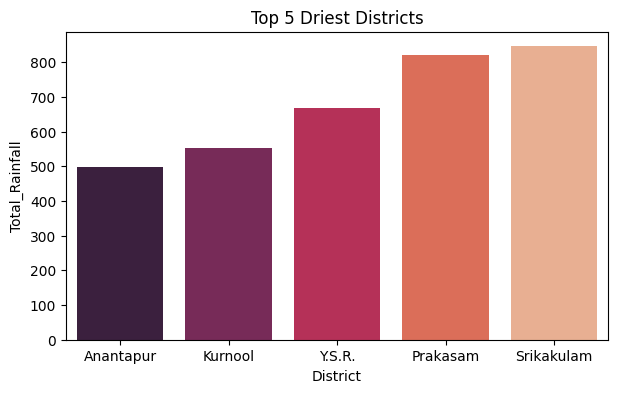

In [25]:
driest = rain_df.groupBy("District").agg(_sum("Avg_rainfall").alias("Total_Rainfall")) \
                .orderBy("Total_Rainfall").limit(5)
driest_pd = driest.toPandas()

plt.figure(figsize=(7,4))
sns.barplot(
    data=driest_pd,
    x="District",
    y="Total_Rainfall",
    hue="District",          
    palette="rocket",
    legend=False             
)

plt.title("Top 5 Driest Districts")
plt.show()


## 📆 Heatmap: Monthly Rainfall by District



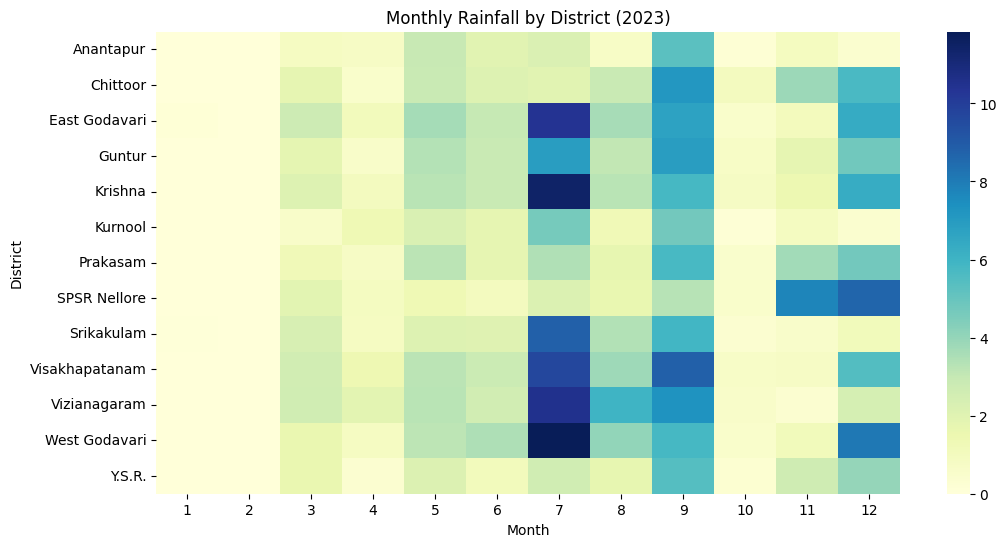

In [26]:
pivot_pd = rain_df.groupBy("District", "Month").agg(avg("Avg_rainfall").alias("Avg_Rainfall")) \
                  .toPandas().pivot(index="District", columns="Month", values="Avg_Rainfall")

plt.figure(figsize=(12,6))
sns.heatmap(pivot_pd, cmap="YlGnBu")
plt.title("Monthly Rainfall by District (2023)")
plt.xlabel("Month")
plt.ylabel("District")
plt.show()


###  Distribution of Rainfall across Districts



In [27]:

plt.rcParams['font.family'] = 'Segoe UI Emoji'

plt.figure(figsize=(10,6))
sns.violinplot(data=district_rain_pd, x="District", y="Avg_rainfall", hue="District", palette="cool", legend=False)
plt.title("🎻 Distribution of Rainfall across Districts")
plt.xlabel("District")
plt.ylabel("Avg Rainfall (mm)")
plt.xticks(rotation=90)
plt.show()

NameError: name 'district_rain_pd' is not defined

<Figure size 1000x600 with 0 Axes>

### Top 3 Rainiest Days



In [ ]:
from pyspark.sql.functions import desc

top10_days = rain_df.orderBy(desc("Avg_rainfall")).limit(10).toPandas()

plt.figure(figsize=(10,5))
sns.barplot(data=top10_days, x="Date", y="Avg_rainfall", hue="Date", legend=False, palette="crest")
plt.title("🌧️ Top 3 Rainiest Days")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.xticks(rotation=45)
plt.show()


# 🏁 Conclusion

The rainfall analysis of **Andhra Pradesh (2023)** using **PySpark** and **data visualization techniques** provided valuable insights into the state’s precipitation trends throughout the year.  

## Key Findings

- 🌦️ **Seasonal Trends:** Rainfall was highest during the **monsoon months (June–September)**, showing a strong seasonal pattern.  
- 📈 **Monthly Variation:** The **average rainfall** gradually increased from pre-monsoon months and peaked in **August and September**, followed by a sharp decline towards the year-end.  
- 🏙️ **District Patterns:** Coastal districts such as **Visakhapatnam, East Godavari, and Srikakulam** experienced significantly higher rainfall compared to interior and Rayalaseema regions like **Anantapur** and **Kurnool**.  
- 📉 **Outliers:** A few districts recorded unusually low rainfall, highlighting regional disparities that could impact agriculture and water resource planning.  
- 🔍 **Correlation Insights:** The correlation heatmap indicated strong relationships between rainfall and time-based factors (month, season), emphasizing the periodic nature of rainfall patterns.

## 🌍 Overall Summary

This project demonstrates the effectiveness of **PySpark** in handling and analyzing large-scale environmental datasets efficiently.  
By integrating **data processing**, **statistical analysis**, and **visualization**, we gained a comprehensive understanding of rainfall distribution and variability across Andhra Pradesh.  

These insights can support:  
- Government agencies in **planning irrigation and water management**  
- Researchers in **climate pattern prediction**  
- Farmers in **decision-making related to crop selection and scheduling**
